# Итоговый проект (часть 1)

# Отток клиентов

## Описание:

От оператора связи стали уходить клиенты. Последние несколько месяцев. Маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

### Цель:

Нужно спрогнозировать отток клиентов

### Глобальная задача:

- Построить модель с предельно большим значением *AUC-ROC*. Чтобы успешно достичь цели, нужно довести метрику до 0.85 или больше на тестовой выборке.

- Сделать информативный и лаконичный отчёт, понятный бизнесу


### Работаем с 4 таблицами:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

### Описание данных:
- BeginDate – дата начала пользования услугами,
- EndDate – дата окончания пользования услугами,
- Type – тип оплаты: ежемесячный, годовой и тд,
- PaperlessBilling – электронный платёжный документ,
- PaymentMethod – способ оплаты,
- MonthlyCharges – ежемесячные траты на услуги по договору,
- TotalCharges – всего потрачено денег на услуги,
- Dependents – наличие иждивенцев,
- Senior Citizen – наличие пенсионного статуса по возрасту,
- Partner – наличие супруга(и),
- MultipleLines – наличие возможности ведения параллельных линий во время звонка

### Библиотеки

In [1]:
import pandas as pd
import numpy as np
import datetime

import time
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.metrics import accuracy_score,roc_auc_score,f1_score,precision_score,recall_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import catboost as cb


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.utils.class_weight import compute_class_weight

In [2]:
import sys

!"{sys.executable}" -m pip install phik
import phik
from phik.report import plot_correlation_matrix

## Обзор данных

**Загружаем датасеты**

In [3]:
contract_data = pd.read_csv('/datasets/contract_new.csv')
personal_data = pd.read_csv('/datasets/personal_new.csv')
internet_data = pd.read_csv('/datasets/internet_new.csv')
phone_data = pd.read_csv('/datasets/phone_new.csv')

### contract_new.csv 

In [4]:
contract_data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


In [5]:
contract_data.shape

(7043, 8)

In [6]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Выводы contract_new.csv:
- Основная таблица
- Стостоит из 7043 строк и 8 столбцов
- В данных нет пропусков
- Нужно изменить регистр, с customerID в CustomerID
- BeginDate, EndDate перевести в формат даты datetime
- TotalCharges перевести в числовой тип float64

### personal_new.csv

In [7]:
personal_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
personal_data.shape

(7043, 5)

In [9]:
personal_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Выводы personal_new.csv:
- Стостоит из 7043 строк и 5 столбцов
- В данных нет пропусков
- Нужно изменить регистр, с customerID в CustomerID и gender в Gender

### internet_new.csv

In [10]:
internet_data.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [11]:
internet_data.shape

(5517, 8)

In [12]:
internet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Выводы internet_new.csv:

- Стостоит из 5517 строк и 8 столбцов
- В данных нет пропусков
- Нужно изменить регистр, с customerID в CustomerID

### phone_new.csv 

In [13]:
phone_data.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [14]:
phone_data.shape

(6361, 2)

In [15]:
phone_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Выводы phone_new.csv:

- Стостоит из 6361 строк и 2 столбца
- В данных нет пропусков
- Нужно изменить регистр, с customerID в CustomerID

### План дальнейших действий:

1. Предобработка данных:
- Переименовать (изменить регистр) в столбцах таблиц
- Изменить типы данных
- Проверить на наличие дубликатов
- Работа с выбросами и аномалиями

2. Подготовка данных к моделированию:
- Обьединить таблицы в одну
- Работа с пропусками
- Работа с распределением признаков
- Кодирование категориальных данных
- Сформировать целевой признак на основе EndDate (добавить новый столбец)

3. Анализ данных (будет использоваться в отчете):
- Исследуем корреляцию между данными
- Дисбаланс классов (не обязательно)

4. Модели:
- Исследуем 3 модели
- Разделение данных на тренировочную и тестовую выборки в соотношении 3к1
- Борьба с дисбалансом на обучаемой выборке (class_weight='balanced')
- Подбираем гиперпараметры на кросс-валидации
- Обучить 3 модели на тренировочной выборке
- Анализ матрицы ошибок
- Выбираем 1 лучшую модель
- Анализ важности признаков
- Считаем и интерпретируем метрику Accuracy (для отчета)
- Пишем выводы по моделированию

5. Отчет:
- Написание отчета по выполненной работе

**Вопросы по задачам:**
- Целевой признак - если EndDate равен No = 0, если стоит дата = 1, верно?
- Можно выбрать эти модели для работы? Логистческая регрессия, Случайный лес, CatBoost?
- Можно ко всем категориальным значениям применить One Hot Encoding?

# Итоговый проект (часть 2)

## Предобработка данных

### Изменение регистра

Переименуем столбцы, чтобы они были с заглавной буквы (в одном формате) 

In [16]:
contract_data = contract_data.rename(columns={'customerID': 'CustomerID'})
print(contract_data.columns.values)

['CustomerID' 'BeginDate' 'EndDate' 'Type' 'PaperlessBilling'
 'PaymentMethod' 'MonthlyCharges' 'TotalCharges']


In [17]:
personal_data = personal_data.rename(columns={'customerID': 'CustomerID', 'gender': 'Gender'})
print(personal_data.columns.values)

['CustomerID' 'Gender' 'SeniorCitizen' 'Partner' 'Dependents']


In [18]:
internet_data = internet_data.rename(columns={'customerID': 'CustomerID'})
print(internet_data.columns.values)

['CustomerID' 'InternetService' 'OnlineSecurity' 'OnlineBackup'
 'DeviceProtection' 'TechSupport' 'StreamingTV' 'StreamingMovies']


In [19]:
phone_data = phone_data.rename(columns={'customerID': 'CustomerID'})
print(phone_data.columns.values)

['CustomerID' 'MultipleLines']


### Проверка на дубликаты

**Неявные дубликаты**

Для удаления неявных дубликатов (если такие есть) приведем все категориальные признаки к нижнему регистру

In [20]:
contract_data['CustomerID'] = contract_data['CustomerID'].str.lower()
contract_data['EndDate'] = contract_data['EndDate'].str.lower()
contract_data['Type'] = contract_data['Type'].str.lower()
contract_data['PaperlessBilling'] = contract_data['PaperlessBilling'].str.lower()
contract_data['PaymentMethod'] = contract_data['PaymentMethod'].str.lower()

In [21]:
personal_data['CustomerID'] = personal_data['CustomerID'].str.lower()
personal_data['Gender'] = personal_data['Gender'].str.lower()
personal_data['Partner'] = personal_data['Partner'].str.lower()
personal_data['Dependents'] = personal_data['Dependents'].str.lower()

In [22]:
internet_data['CustomerID'] = internet_data['CustomerID'].str.lower()
internet_data['InternetService'] = internet_data['InternetService'].str.lower()
internet_data['OnlineSecurity'] = internet_data['OnlineSecurity'].str.lower()
internet_data['OnlineBackup'] = internet_data['OnlineBackup'].str.lower()
internet_data['DeviceProtection'] = internet_data['DeviceProtection'].str.lower()
internet_data['TechSupport'] = internet_data['TechSupport'].str.lower()
internet_data['StreamingTV'] = internet_data['StreamingTV'].str.lower()
internet_data['StreamingMovies'] = internet_data['StreamingMovies'].str.lower()

In [23]:
phone_data['CustomerID'] = phone_data['CustomerID'].str.lower()
phone_data['MultipleLines'] = phone_data['MultipleLines'].str.lower()

**Явные дубликаты** 

In [24]:
print("Явных дубликатов в таблице contract_new:", contract_data.duplicated().sum())
print("Явных дубликатов в таблице personal_new:", personal_data.duplicated().sum())
print("Явных дубликатов в таблице internet_new:", internet_data.duplicated().sum())
print("Явных дубликатов в таблице phone_new:", phone_data.duplicated().sum())

Явных дубликатов в таблице contract_new: 0
Явных дубликатов в таблице personal_new: 0
Явных дубликатов в таблице internet_new: 0
Явных дубликатов в таблице phone_new: 0


Дубликатов не выявлено

### Добавим целевой признак

In [25]:
contract_data['EndDate'].value_counts()

no            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

Определим целевой признак опираясь на 'EndDate', создав новую перепенную. Договорам, которые прекратили действие, присвоим значение 1, Договорам с значением "No" присвоим значение 0. Добавим столбец с таргетом в таблицус контрактами

In [26]:
contract_data["Target"] = 0
contract_data.loc[contract_data['EndDate'] <= '2020-02-01', 'Target'] = 1

In [27]:
contract_data['Target'].value_counts()

0    5942
1    1101
Name: Target, dtype: int64

Значений "no" в 'EndDate' 5942, что соответствует количеству значений "0" в 'Target'

### Изменить типы данных

In [28]:
contract_data['BeginDate'].value_counts()

2014-02-01    366
2019-09-01    237
2019-10-01    237
2019-11-01    237
2020-01-01    233
             ... 
2020-02-01     11
2014-01-01      7
2013-12-01      3
2013-10-01      3
2013-11-01      2
Name: BeginDate, Length: 77, dtype: int64

Крайняя дата заключения договора - 2020-02-01, предположим, что именно в феврале 2020 года эти данные и были выгружены

In [29]:
contract_data['EndDate'].value_counts()

no            5942
2020-01-01      39
2019-12-01      38
2018-11-01      35
2019-09-01      32
              ... 
2015-04-01       2
2014-12-01       2
2014-06-01       1
2014-11-01       1
2014-10-01       1
Name: EndDate, Length: 67, dtype: int64

Заменим все значения 'no' в 'EndDate' на дату выгрузки (01.02.2020)

In [30]:
contract_data.loc[(contract_data['EndDate'] == 'no'),'EndDate'] = '2020-02-01'

Приведем данные 'BeginDate' и 'EndDate' к datetime

In [31]:
contract_data['BeginDate'] = pd.to_datetime(contract_data['BeginDate'], format='%Y-%m-%d')
contract_data['EndDate'] = pd.to_datetime(contract_data['EndDate'], format='%Y-%m-%d')

In [32]:
contract_data['TotalCharges'].value_counts()

           11
20.45       6
101.0       5
40.1        4
1007.5      4
           ..
5707.1      1
152.71      1
1620.35     1
3869.5      1
1640.56     1
Name: TotalCharges, Length: 6658, dtype: int64

У 11 клиентов сумарный платеж отсутстует

In [33]:
contract_data.query('TotalCharges == " "')

,CustomerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target
488,4472-lvygi,2020-02-01,2020-02-01,two year,yes,bank transfer (automatic),52.55,,0
753,3115-czmzd,2020-02-01,2020-02-01,two year,no,mailed check,20.25,,0
936,5709-lvoeq,2020-02-01,2020-02-01,two year,no,mailed check,80.85,,0
1082,4367-nuyao,2020-02-01,2020-02-01,two year,no,mailed check,25.75,,0
1340,1371-dwpaz,2020-02-01,2020-02-01,two year,no,credit card (automatic),56.05,,0
3331,7644-omvmy,2020-02-01,2020-02-01,two year,no,mailed check,19.85,,0
3826,3213-vvolg,2020-02-01,2020-02-01,two year,no,mailed check,25.35,,0
4380,2520-sgtta,2020-02-01,2020-02-01,two year,no,mailed check,20.00,,0
5218,2923-arzlg,2020-02-01,2020-02-01,one year,yes,mailed check,19.70,,0
6670,4075-wkniu,2020-02-01,2020-02-01,two year,no,mailed check,73.35,,0


Это клиенты, подписавышие договор на момент выгрузки данных (2020-02-01), они еще не успели совершить платеж. Заполним пропущенные значения нулями и изменим тип данных

In [34]:
contract_data.loc[(contract_data['TotalCharges'] == ' '),'TotalCharges'] = '0.00'
contract_data['TotalCharges'] = contract_data['TotalCharges'].astype(float)

In [35]:
contract_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   CustomerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Target            7043 non-null   int64         
dtypes: datetime64[ns](2), float64(2), int64(1), object(4)
memory usage: 495.3+ KB


### Объединение датасетов

In [36]:
data = contract_data \
    .merge(personal_data, how='left', on='CustomerID') \
    .merge(internet_data, how='left', on='CustomerID') \
    .merge(phone_data, how='left', on='CustomerID') 

In [37]:
data.shape

(7043, 21)

Проверим CustomerID на уникальность

In [38]:
data['CustomerID'].is_unique

True

CustomerID важен, но для моделей не нужен, установим его вместо индекса в датасете

In [39]:
data = data.set_index('CustomerID')

In [40]:
data.shape

(7043, 20)

Количество столбцов сократилось на 1

In [41]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
CustomerID,,,,,,,,,,,,,,,,,,,,
7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,0,female,0,yes,no,dsl,no,yes,no,no,no,no,NaN
5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,0,male,0,no,no,dsl,yes,no,yes,no,no,no,no
3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,0,male,0,no,no,dsl,yes,yes,no,no,no,no,no
7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,0,male,0,no,no,dsl,yes,no,yes,yes,no,no,NaN
9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,0,female,0,no,no,fiber optic,no,no,no,no,no,no,no


In [42]:
data.describe()

,MonthlyCharges,TotalCharges,Target,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,0.156325,0.162147
std,30.090047,2112.742814,0.363189,0.368612
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,436.750000,0.000000,0.000000
50%,70.350000,1343.350000,0.000000,0.000000
75%,89.850000,3236.690000,0.000000,0.000000
max,118.750000,9221.380000,1.000000,1.000000


In [43]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-vhveg to 3186-ajiek
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   int64         
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   5517 non-null   object        
 13  OnlineSecurity    5517 non-null   object        
 14  OnlineBackup  

Наблюдаем пропуски в InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, StreamingMovies и MultipleLines

Не обязательно клиент должен был преобретать все услуги, он мог чем-то не пользоваться. И пропуски означают, что эти услуги не были подключены. 

Заменим появившиеся пропуски в таблице на "no"

In [44]:
for column in ('InternetService', 
               'OnlineSecurity', 
               'OnlineBackup', 
               'DeviceProtection', 
               'TechSupport', 
               'StreamingTV', 
               'StreamingMovies', 
               'MultipleLines'
              ):
    data[column] = data[column].fillna('no')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-vhveg to 3186-ajiek
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   datetime64[ns]
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   float64       
 7   Target            7043 non-null   int64         
 8   Gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  InternetService   7043 non-null   object        
 13  OnlineSecurity    7043 non-null   object        
 14  OnlineBackup  

Итого: датасеты обьединили в один, от всех пропусков в данных избавились

Создадим новый столбец Days, который покажет, сколько дней человек является клиентом

In [46]:
data['Days'] = (data['EndDate'] - data['BeginDate']).dt.days

In [47]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Target,Gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,Days
CustomerID,,,,,,,,,,,,,,,,,,,,,
7590-vhveg,2020-01-01,2020-02-01,month-to-month,yes,electronic check,29.85,31.04,0,female,0,...,no,dsl,no,yes,no,no,no,no,no,31
5575-gnvde,2017-04-01,2020-02-01,one year,no,mailed check,56.95,2071.84,0,male,0,...,no,dsl,yes,no,yes,no,no,no,no,1036
3668-qpybk,2019-10-01,2020-02-01,month-to-month,yes,mailed check,53.85,226.17,0,male,0,...,no,dsl,yes,yes,no,no,no,no,no,123
7795-cfocw,2016-05-01,2020-02-01,one year,no,bank transfer (automatic),42.30,1960.60,0,male,0,...,no,dsl,yes,no,yes,yes,no,no,no,1371
9237-hqitu,2019-09-01,2020-02-01,month-to-month,yes,electronic check,70.70,353.50,0,female,0,...,no,fiber optic,no,no,no,no,no,no,no,153


## Исследовательский анализ данных

### Определим количественные и категориальные значения в датасете

In [48]:
numeric_columns = ['MonthlyCharges', 'TotalCharges', 'Days']
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]

### Матрица корреляции phik

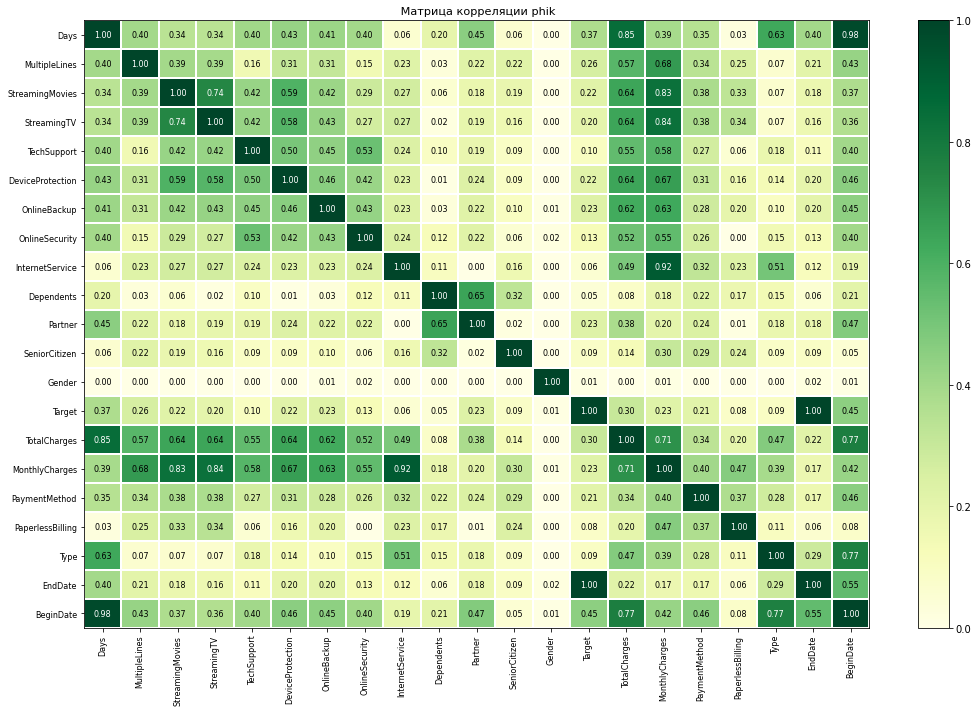

In [49]:
phik_mat = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'Days'])
plot_correlation_matrix(phik_mat.values, x_labels=phik_mat.columns, y_labels=phik_mat.index, 
                        vmin=0, vmax=1, color_map="YlGn", title=" Матрица корреляции phik", 
                        fontsize_factor=0.8, figsize=(15, 10))
plt.show()

В матрице видны скоррелированные предикторы, создающие эффект мультиколлинеарности.

Мультиколлинеарность можно отслеживать по коэффициенту корреляции между предикторами >=0.8

Days - TotalCharges

Days - BeginDate

InternetService - MonthlyCharges

Target - EndDate

StreamingMovies - MonthlyCharges

StreamingTV - MonthlyCharges

При выборке признака для удаления можно стандартно ориентироваться на коэффициенты корреляции каждого из пары скоррелированных предикторов с целевым признаком и удалить тот, у которого связь с целевым признаком ниже

Перед началом моделирования удалим следующие признаки: TotalCharges, BeginDate, EndDate, InternetService, StreamingMovies, StreamingTV 

### Распределение значений для количественных данных

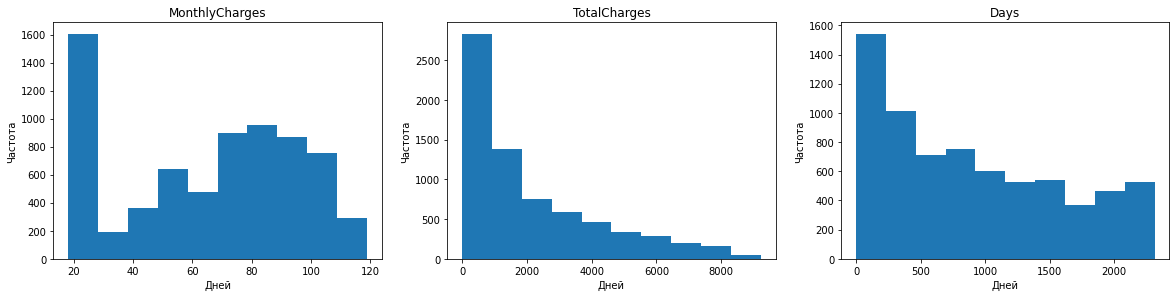

In [50]:
cols = 3
rows = 4
plt.figure(figsize=(20, 20))

idx = 0
for column in numeric_columns:
    idx += 1 
    
    plt.subplot(rows, cols, idx)
    plt.hist(data[column])
    plt.ylabel('Частота')
    plt.xlabel('Дней')
    plt.title(column)
        
plt.show()

In [51]:
display(data[numeric_columns].describe())

,MonthlyCharges,TotalCharges,Days
count,7043.000000,7043.000000,7043.000000
mean,64.761692,2115.312885,898.555729
std,30.090047,2112.742814,683.130510
min,18.250000,0.000000,0.000000
25%,35.500000,436.750000,276.000000
50%,70.350000,1343.350000,761.000000
75%,89.850000,3236.690000,1461.000000
max,118.750000,9221.380000,2314.000000


- В столбце MonthlyCharges наблюдаем 2 пика, первый пик связан с тем, что клиент может в первый месяц оплатить годовой контракт
- В столбце MonthlyCharges второй пик в районе 85
- Значения в столбце TotalCharges постепенно убывает
- Клиенты, которые много платят за тариф на долго не остаются

In [52]:
data[numeric_columns].corr()

,MonthlyCharges,TotalCharges,Days
MonthlyCharges,1.000000,0.630440,0.220054
TotalCharges,0.630440,1.000000,0.821746
Days,0.220054,0.821746,1.000000


Высокая корреляция между TotalCharges и остальными признаками, поэтому данный столбец не будем учитывать в моделировании 

### Распределение значений для категориальных данных

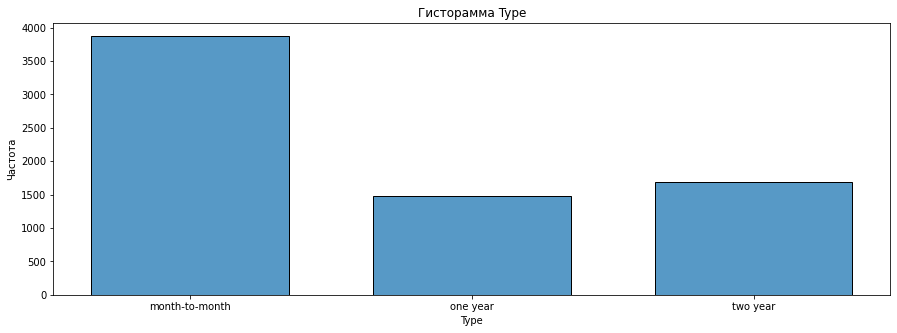

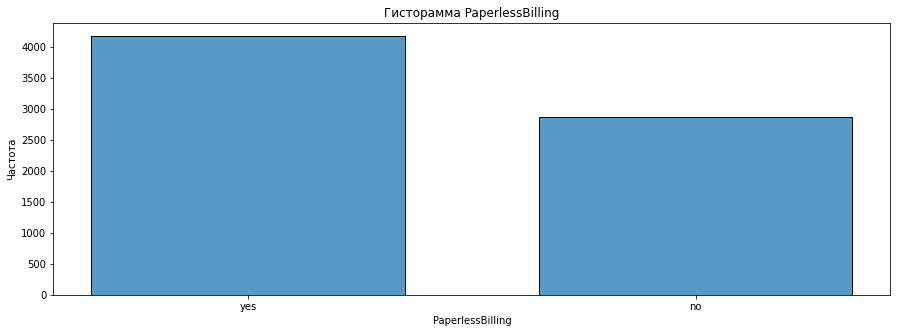

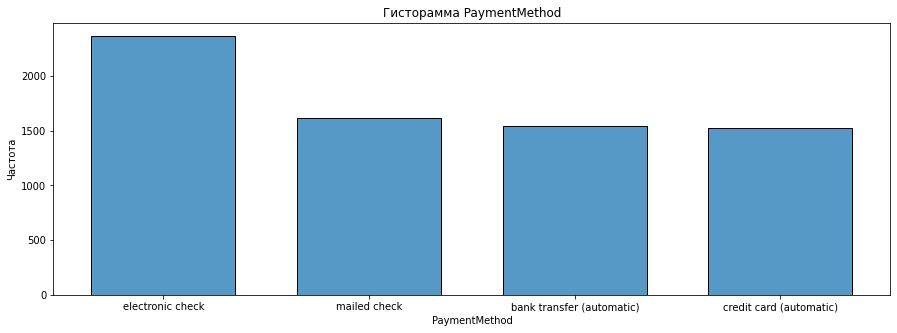

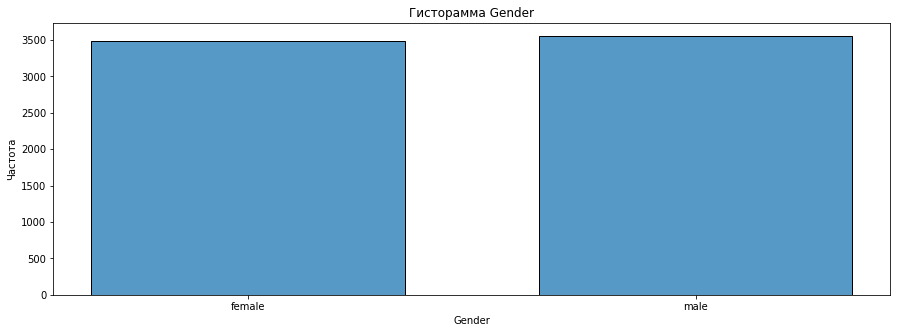

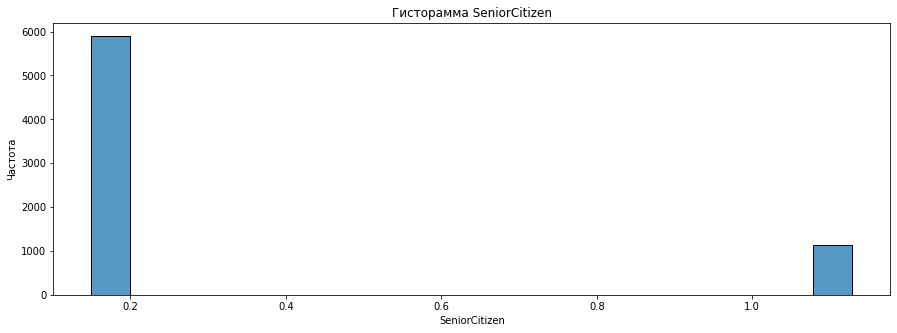

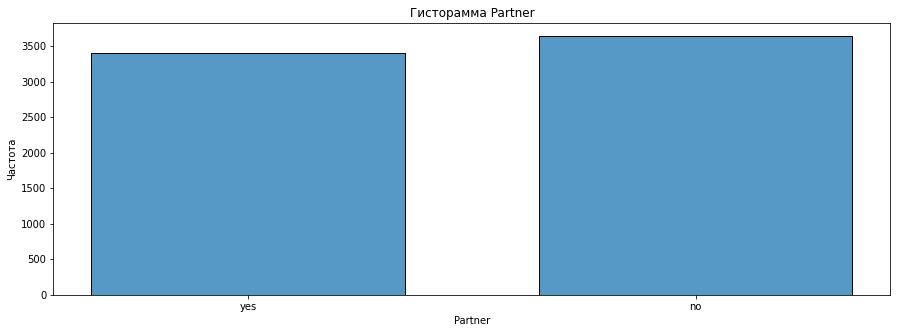

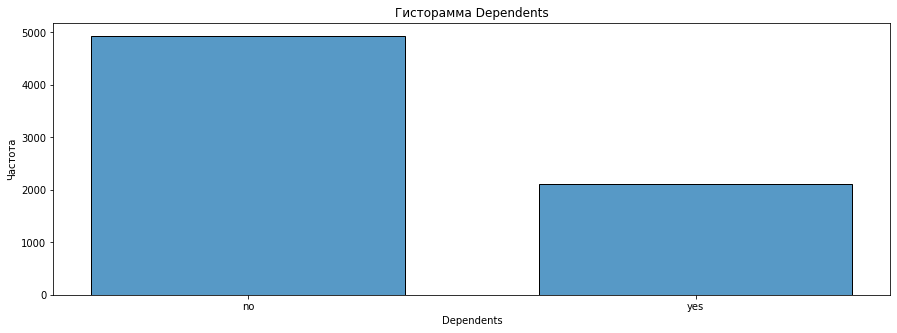

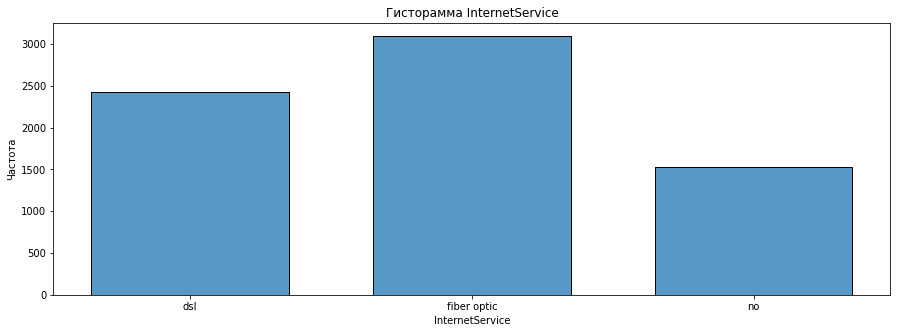

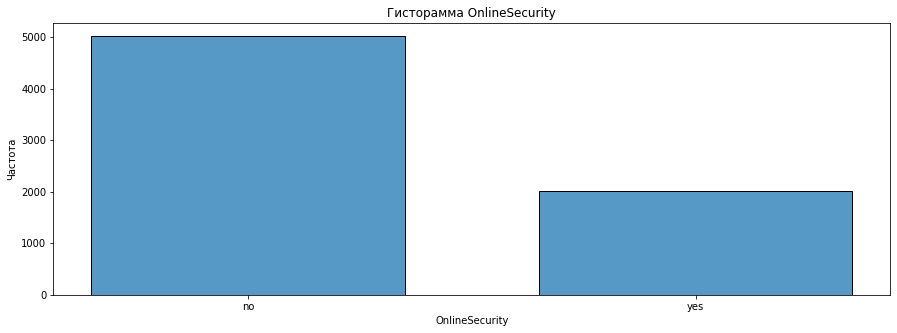

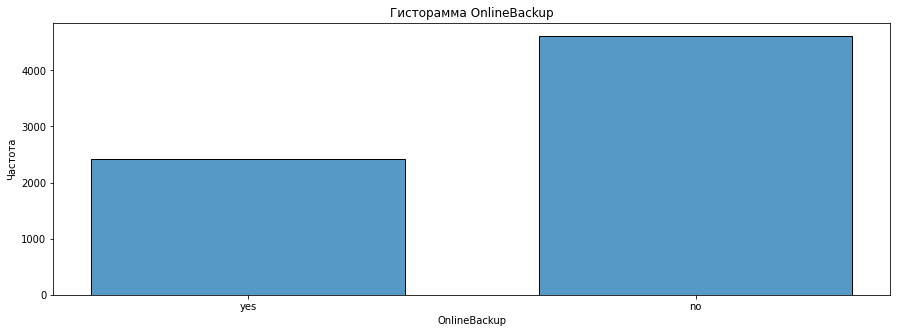

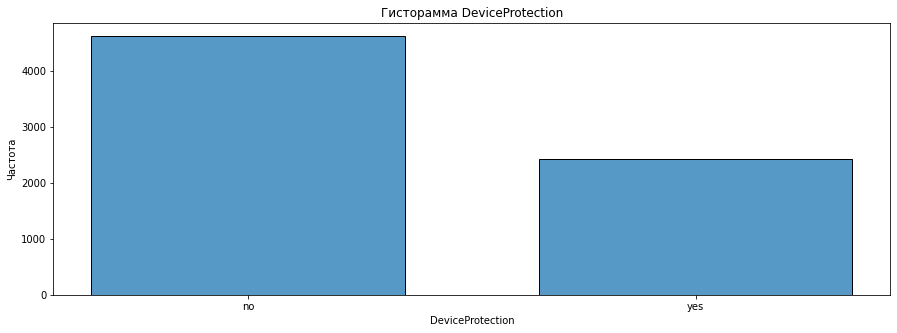

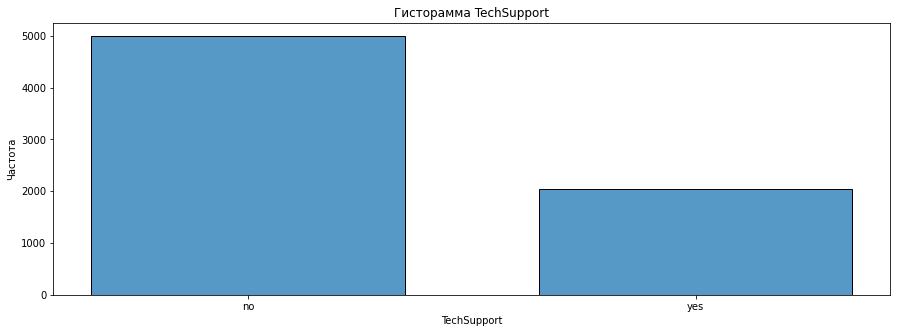

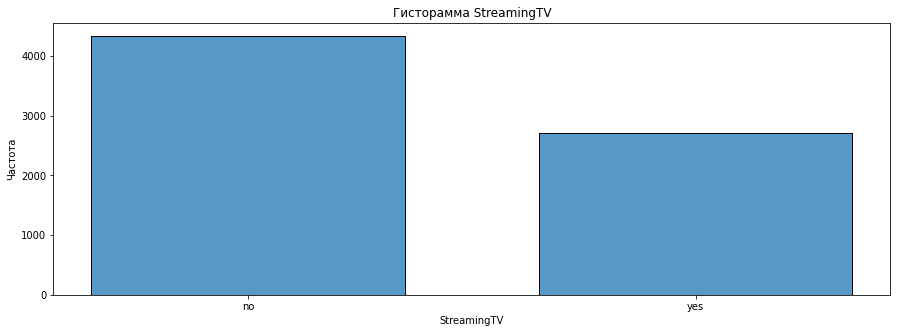

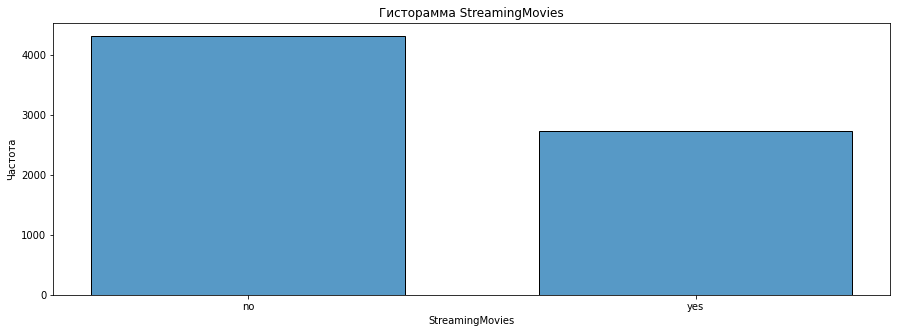

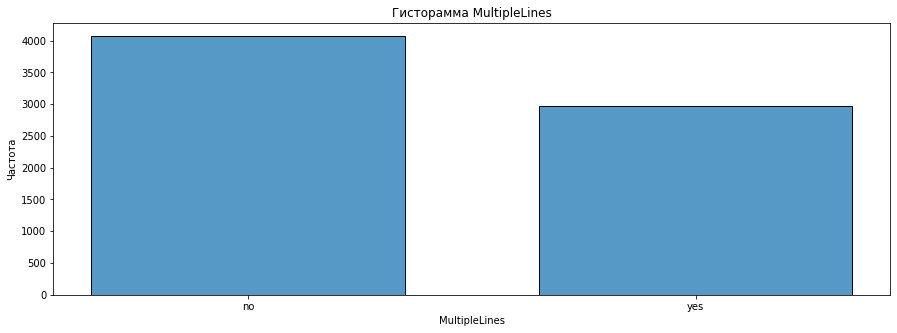

In [53]:
for i in [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]:
    plt.figure(figsize=(15,5))
    sns.histplot(data=data,x=i, shrink= .7, multiple="dodge")
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

- Помесячный способ оплаты самый распространенный
- Большинство криентов неприклонного возраста
- Чаще всего клиенты оплачивают счета при помощи электронного чека
- Оптоволокно более популярный метод подключения интернета
- Чаще всего пользователи отказываются от дополнительных услуг оператора

### Распределение категорильных значений относительно целевого признака

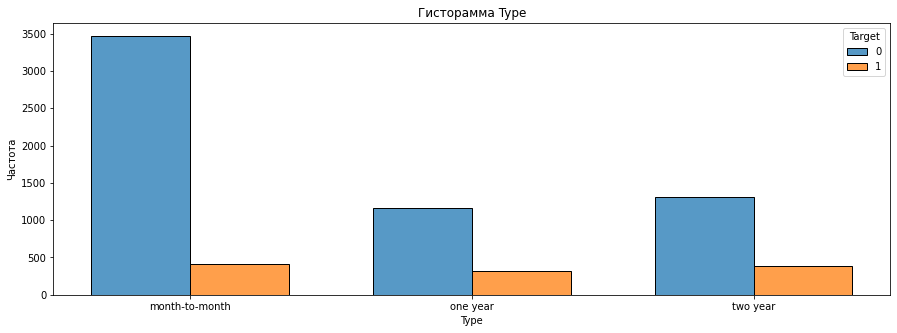

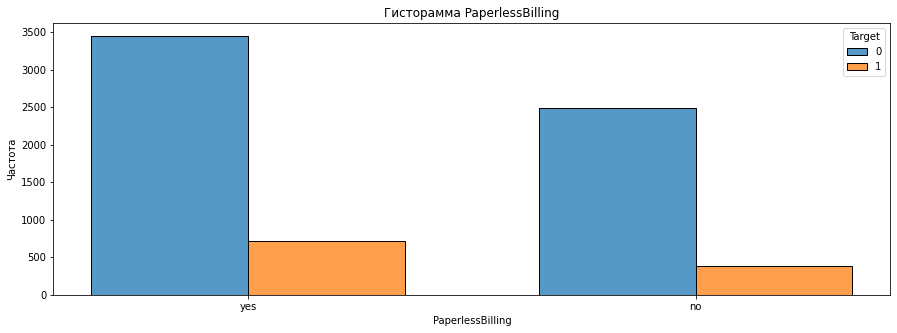

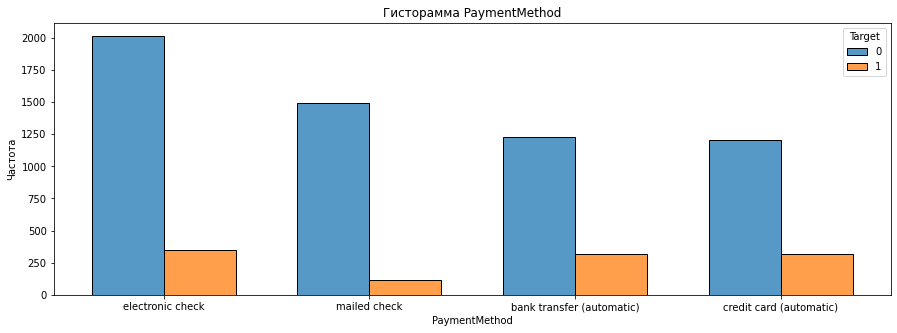

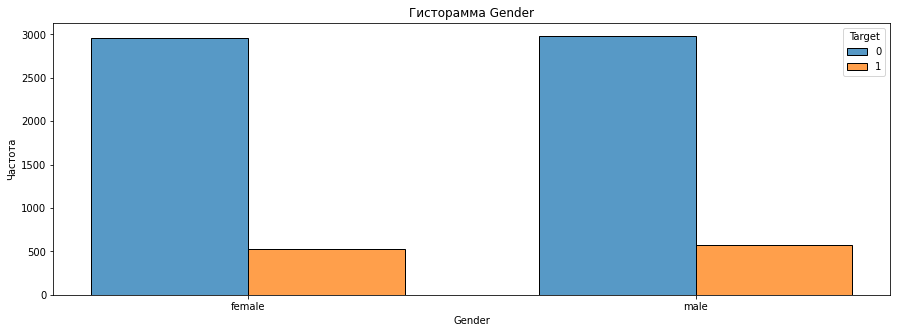

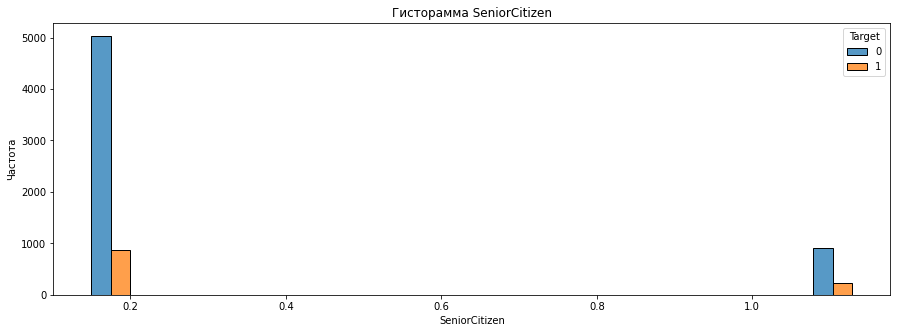

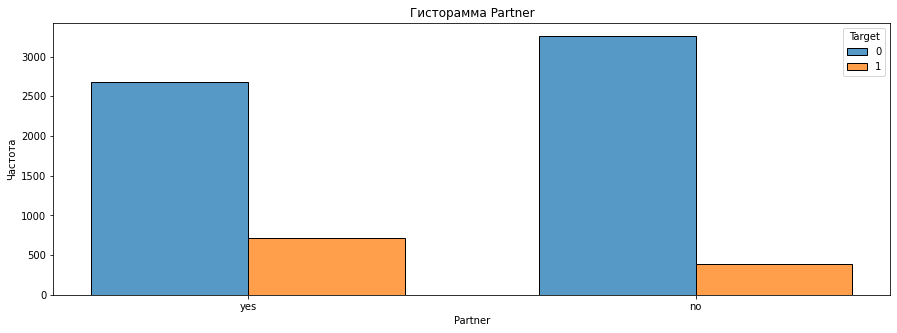

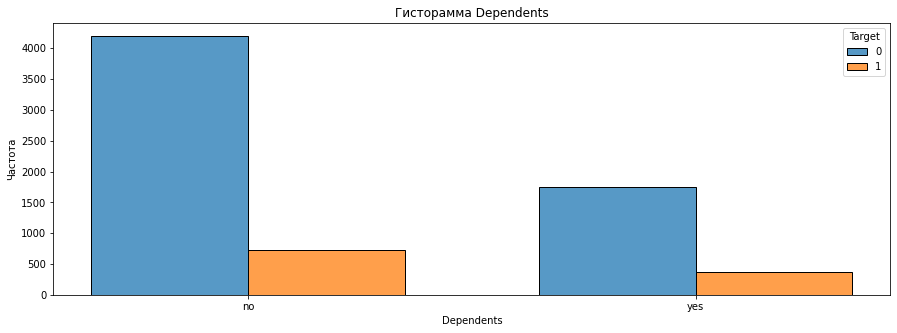

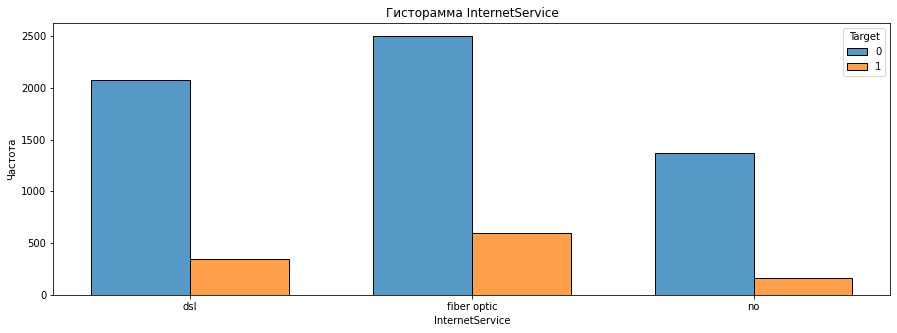

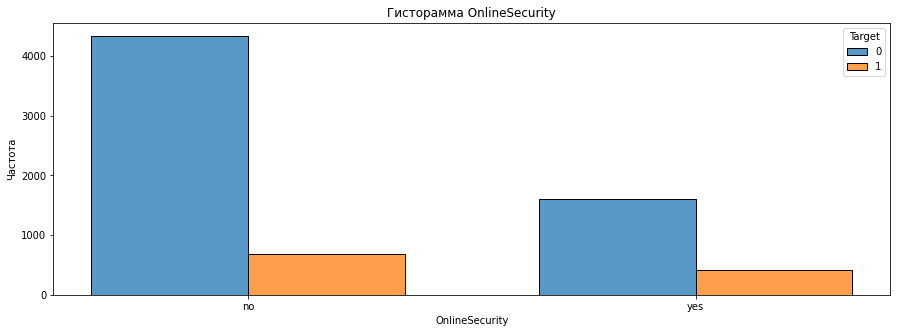

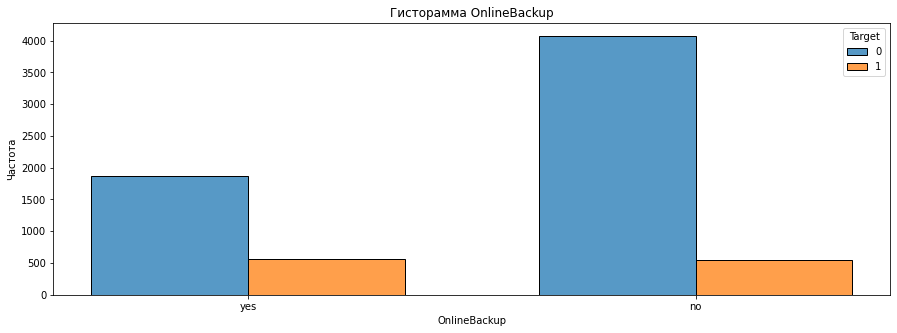

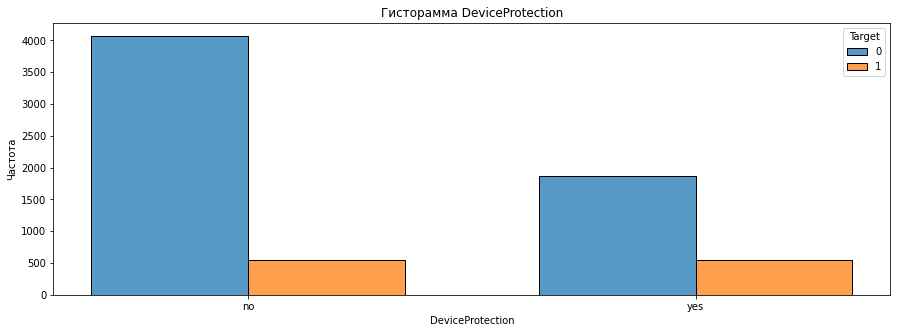

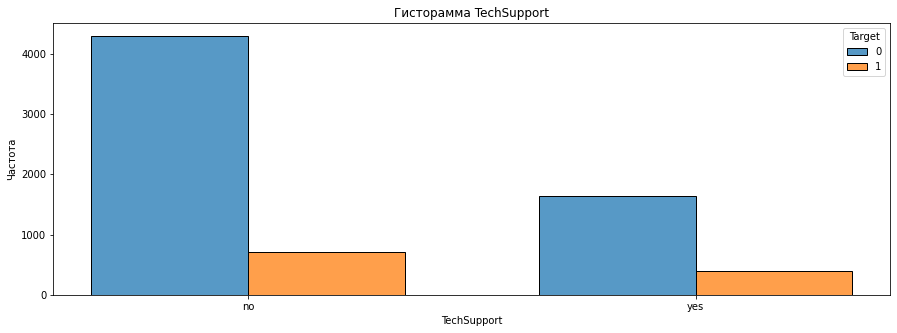

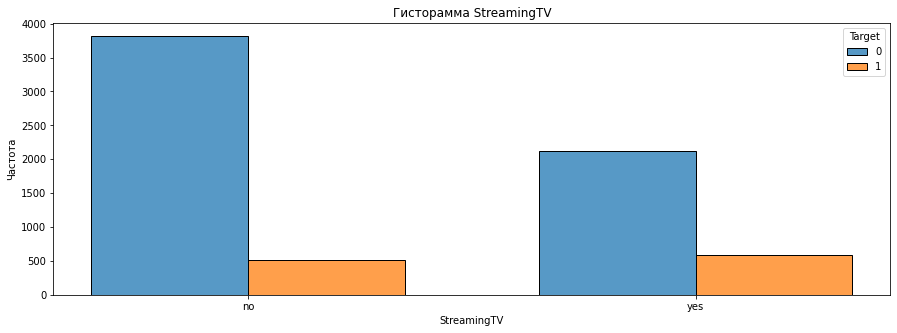

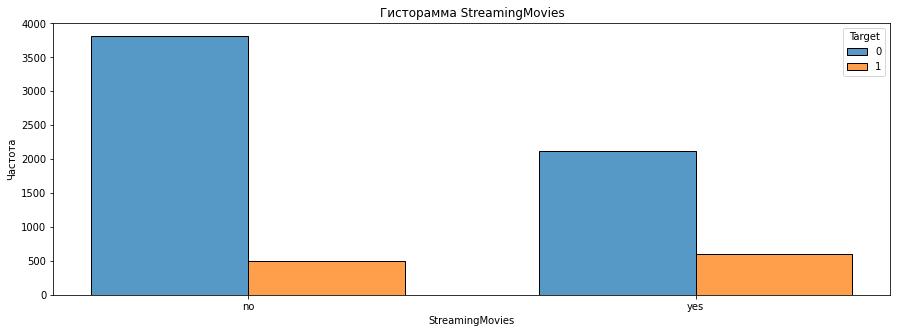

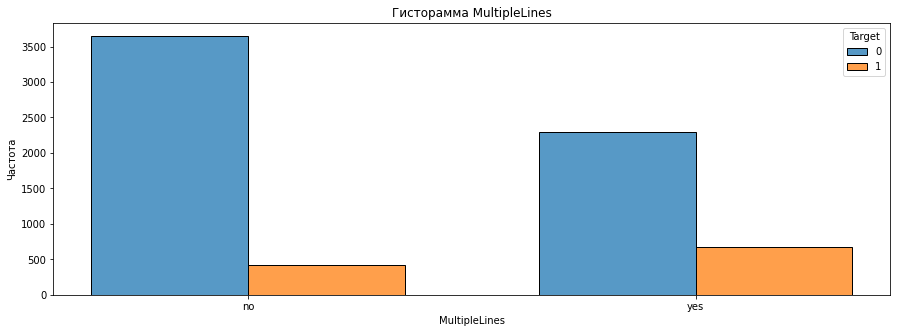

In [54]:
for i in [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents',
    'InternetService', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'StreamingTV', 
    'StreamingMovies', 
    'MultipleLines',
]:
    plt.figure(figsize=(15,5))
    sns.histplot(data=data,x=i,hue='Target', shrink= .7, multiple="dodge")
    plt.ylabel('Частота')
    plt.xlabel(i)
    plt.title(f'Гисторамма {i}')
    plt.show()

- Доля отказов при помесячнуй оплате выше
- Пенсионеры чаще отказываются от услуг
- Клиенты, которые производят оплату чеком чаще всего отказываются от услуг.
- Дополнительные услуги особо не влияют на отказы, так как большинство клиентов отказываются от интернет услуг, что видно на InternetService 

## Моделирование

### Условия

RANDOM_STATE=190623

Пороговое значение основной метрики - >= 0.85

Дополнительно (для отчёта) считаем и интерпретируем метрику Accuracy

Соотношение train/test = 3/1

Используем кросс-валидацию

Анализ матрицы ошибок

### Подготовка данных для моделей

- Для дальнейшего построения моделей оставим все категориальные признаки
- Из количественных признаков удалим информацию про общее количество потраченных денег

Удалим столбцы ненужные для обучения:  BeginDate, EndDate и TotalCharges

In [55]:
data = data.drop(['BeginDate', 'EndDate', 'TotalCharges', 'InternetService', 'StreamingMovies', 'StreamingTV'], axis=1)

После удаления обновим numeric_columns 

In [56]:
numeric_columns = ['MonthlyCharges', 'Days']

После удаления обновим categorial_columns 

In [57]:
categorial_columns = [
    'Type',
    'PaperlessBilling',
    'PaymentMethod',
    'Gender',
    'SeniorCitizen',
    'Partner',
    'Dependents', 
    'OnlineSecurity', 
    'OnlineBackup', 
    'DeviceProtection', 
    'TechSupport', 
    'MultipleLines',
]

### Скопируем датасет в отдельные переменные

In [58]:
cat_data = data.copy()

In [59]:
f_data = data.copy()

In [60]:
log_data = data.copy()

### Кодирование категориальных признаков

Порядковое кодирование (Ordinal Encoding) позволяет закодировать категории цифрами, с помощью номера категории.
Подходит для преобразования признаков в решающем дереве, случайном лесе, когда все признаки категориальные, и их нужно преобразовать в числа.

Ordinal Encoding не подходит для логистической регрессии, в данном случае будем использовать прямое кодирование (One-Hot Encoding, get_dummies)

#### Ordinal Encoding

**Подготовим выборки для обучения моделей**

In [61]:
RANDOM_STATE=190623
f_target = f_data['Target']
f_features = f_data.drop('Target', axis=1)
f_features_train, f_features_test, f_target_train, f_target_test = train_test_split(
    f_features, f_target, test_size=0.25, random_state=RANDOM_STATE)

In [63]:
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
encoder.fit(f_features_train[categorial_columns])

OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

In [64]:
f_features_train[categorial_columns] = encoder.transform(f_features_train[categorial_columns])

In [65]:
f_features_test[categorial_columns] = encoder.transform(f_features_test[categorial_columns])

**Проверим размер выборки**

In [66]:
f_train_sample=f_features_train.shape[0]/f_features.shape[0]
f_test_sample=f_target_test.shape[0]/f_target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(f_train_sample))
print('Размер тестовой выборки - {:.0%}'.format(f_test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


**Применим масштабирование с помощью StandardScaler**

In [67]:
scaler = StandardScaler()
scaler.fit(f_features_train[numeric_columns])
f_features_train[numeric_columns] = scaler.transform(f_features_train[numeric_columns])
f_features_test[numeric_columns] = scaler.transform(f_features_test[numeric_columns]) 
print(f_features_train.head())

            Type  PaperlessBilling  PaymentMethod  MonthlyCharges  Gender  \
CustomerID                                                                  
6670-mfrpk   2.0               1.0            1.0        0.500345     1.0   
5574-nxziu   2.0               0.0            1.0        1.495798     1.0   
5939-sxwhm   2.0               0.0            0.0       -1.254970     1.0   
0214-jhpfw   2.0               0.0            0.0       -0.209745     0.0   
2348-kcjlt   1.0               1.0            3.0       -0.086972     0.0   

            SeniorCitizen  Partner  Dependents  OnlineSecurity  OnlineBackup  \
CustomerID                                                                     
6670-mfrpk            0.0      1.0         1.0             0.0           0.0   
5574-nxziu            0.0      0.0         0.0             1.0           1.0   
5939-sxwhm            0.0      1.0         1.0             0.0           0.0   
0214-jhpfw            0.0      1.0         0.0             0

**Проверка выборок**

In [68]:
f_cl1 = f_features_train.columns
f_cl2 = f_features_test.columns
  
print("features_train_columns:")
print(f_cl1)
print("\nfeatures_test_columns:")
print(f_cl2)
  
print("\nСравнение признаков двух приведенных серий:")
print("\nСовпадение:")
print(f_cl1 == f_cl2)

features_train_columns:
Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines',
       'Days'],
      dtype='object')

features_test_columns:
Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'Gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'MultipleLines',
       'Days'],
      dtype='object')

Сравнение признаков двух приведенных серий:

Совпадение:
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True]


#### get_dummies

**Разделим на выборки**

In [69]:
RANDOM_STATE=190623
target = data['Target']
features = data.drop('Target', axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE)

**Проведем кодирование**

In [70]:
features_train = pd.get_dummies(features_train, drop_first=True)

In [71]:
features_test = pd.get_dummies(features_test, drop_first=True)

**Проверка выборок**

In [72]:
cl1 = features_train.columns
cl2 = features_test.columns
  
print("features_train_columns:")
print(cl1)
print("\nfeatures_test_columns:")
print(cl2)
  
print("\nСравнение признаков двух приведенных серий:")
print("\nСовпадение:")
print(cl1 == cl2)

features_train_columns:
Index(['MonthlyCharges', 'SeniorCitizen', 'Days', 'Type_one year',
       'Type_two year', 'PaperlessBilling_yes',
       'PaymentMethod_credit card (automatic)',
       'PaymentMethod_electronic check', 'PaymentMethod_mailed check',
       'Gender_male', 'Partner_yes', 'Dependents_yes', 'OnlineSecurity_yes',
       'OnlineBackup_yes', 'DeviceProtection_yes', 'TechSupport_yes',
       'MultipleLines_yes'],
      dtype='object')

features_test_columns:
Index(['MonthlyCharges', 'SeniorCitizen', 'Days', 'Type_one year',
       'Type_two year', 'PaperlessBilling_yes',
       'PaymentMethod_credit card (automatic)',
       'PaymentMethod_electronic check', 'PaymentMethod_mailed check',
       'Gender_male', 'Partner_yes', 'Dependents_yes', 'OnlineSecurity_yes',
       'OnlineBackup_yes', 'DeviceProtection_yes', 'TechSupport_yes',
       'MultipleLines_yes'],
      dtype='object')

Сравнение признаков двух приведенных серий:

Совпадение:
[ True  True  True  True  True

### Подготовим выборки для обучения моделей

**Проверим размер выборки**

In [73]:
train_sample=features_train.shape[0]/features.shape[0]
test_sample=target_test.shape[0]/target.shape[0]

print('Размер тренировочной выборки- {:.0%}'.format(train_sample))
print('Размер тестовой выборки - {:.0%}'.format(test_sample))

Размер тренировочной выборки- 75%
Размер тестовой выборки - 25%


Соотношение 3к1, как и нужно

**Применим масштабирование с помощью StandardScaler**

In [74]:
scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns]) 
print(features_train.head())

            MonthlyCharges  SeniorCitizen      Days  Type_one year  \
CustomerID                                                           
6670-mfrpk        0.500345              0  1.764395              0   
5574-nxziu        1.495798              0  1.495149              0   
5939-sxwhm       -1.254970              0  0.201594              0   
0214-jhpfw       -0.209745              0  1.050306              0   
2348-kcjlt       -0.086972              0  0.649363              1   

            Type_two year  PaperlessBilling_yes  \
CustomerID                                        
6670-mfrpk              1                     1   
5574-nxziu              1                     0   
5939-sxwhm              1                     0   
0214-jhpfw              1                     0   
2348-kcjlt              0                     1   

            PaymentMethod_credit card (automatic)  \
CustomerID                                          
6670-mfrpk                                   

### Построение моделей

#### Модель "Логистическая регрессия"

In [75]:
%%time

regression = LogisticRegression(solver='lbfgs', fit_intercept=True, n_jobs=None, random_state=RANDOM_STATE)

regression_cv_score = pd.Series(cross_val_score(regression,features_train,target_train,scoring='roc_auc')).mean()

CPU times: user 878 ms, sys: 2.66 s, total: 3.54 s
Wall time: 3.49 s


In [76]:
print('Среднее качество модели линейной регрессии на кросс-валидации:', regression_cv_score)

Среднее качество модели линейной регрессии на кросс-валидации: 0.752462685296795


#### Модель "Случайный лес"

In [77]:
%%time

forest = RandomForestClassifier(random_state=RANDOM_STATE)

forest_parametrs = { 'n_estimators': range(5, 30, 5),
                     'max_depth': range(1, 7),
                     'min_samples_leaf': range(1,5),
                     'min_samples_split': range(2,8,2) }


forest_grid = GridSearchCV(forest, forest_parametrs, scoring='roc_auc')
forest_grid.fit(f_features_train, f_target_train)

CPU times: user 1min 16s, sys: 454 ms, total: 1min 17s
Wall time: 1min 19s


GridSearchCV(estimator=RandomForestClassifier(random_state=190623),
             param_grid={'max_depth': range(1, 7),
                         'min_samples_leaf': range(1, 5),
                         'min_samples_split': range(2, 8, 2),
                         'n_estimators': range(5, 30, 5)},
             scoring='roc_auc')

In [78]:
forest_params = forest_grid.best_params_
print("Лучшие параметры модели:", forest_params)

Лучшие параметры модели: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 20}


In [79]:
scores_forest_cv = forest_grid.best_score_
print('Среднее качество модели случайный лес на кросс-валидации:', scores_forest_cv)

Среднее качество модели случайный лес на кросс-валидации: 0.8218858627674933


#### Модель "CatBoost"

In [80]:
%%time

cb = CatBoostClassifier(random_state=RANDOM_STATE)

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='roc_auc')
cb_grid.fit(features_train, target_train, verbose=100)

0:	learn: 0.6718203	total: 50.6ms	remaining: 50.5s
100:	learn: 0.3301505	total: 163ms	remaining: 1.45s
200:	learn: 0.3087591	total: 274ms	remaining: 1.09s
300:	learn: 0.2926843	total: 398ms	remaining: 925ms
400:	learn: 0.2737805	total: 519ms	remaining: 775ms
500:	learn: 0.2556058	total: 632ms	remaining: 629ms
600:	learn: 0.2399471	total: 758ms	remaining: 503ms
700:	learn: 0.2291884	total: 876ms	remaining: 374ms
800:	learn: 0.2174465	total: 998ms	remaining: 248ms
900:	learn: 0.2075345	total: 1.15s	remaining: 126ms
999:	learn: 0.1951863	total: 1.28s	remaining: 0us
0:	learn: 0.6699844	total: 1.87ms	remaining: 1.86s
100:	learn: 0.3288887	total: 120ms	remaining: 1.07s
200:	learn: 0.3075035	total: 235ms	remaining: 935ms
300:	learn: 0.2893568	total: 360ms	remaining: 836ms
400:	learn: 0.2697041	total: 486ms	remaining: 725ms
500:	learn: 0.2509078	total: 607ms	remaining: 605ms
600:	learn: 0.2371535	total: 730ms	remaining: 484ms
700:	learn: 0.2262490	total: 840ms	remaining: 358ms
800:	learn: 0.21

GridSearchCV(estimator=<catboost.core.CatBoostClassifier object at 0x7fb35d7ce730>,
             param_grid={'depth': [4, 6, 10], 'learning_rate': [0.03, 0.1]},
             scoring='roc_auc')

In [81]:
cb_params = cb_grid.best_params_
print("Лучшие параметры модели:", cb_params)

Лучшие параметры модели: {'depth': 4, 'learning_rate': 0.1}


In [82]:
scores_cv_cat = cb_grid.best_score_
print('Среднее качество модели CatBoost на кросс-валидации:', scores_cv_cat)

Среднее качество модели CatBoost на кросс-валидации: 0.9229824039480266


### Сравним ROC-AUC моделей на обучающихся выборках

In [96]:
column=['Среднее качество модели на кросс-валидации']

comparison_tabl = pd.DataFrame(index=['Среднее качество модели на кросс-валидации'], columns=['LogisticRegression','RandomForestClassifier','CatBoostClassifier'])
comparison_tabl['LogisticRegression'] = regression_cv_score
comparison_tabl['RandomForestClassifier'] = scores_forest_cv
comparison_tabl['CatBoostClassifier'] = scores_cv_cat

comparison_tabl.T.style.highlight_min(color='red',subset=column).highlight_max(color='green',subset=column)

,Среднее качество модели на кросс-валидации
LogisticRegression,0.752463
RandomForestClassifier,0.821886
CatBoostClassifier,0.922982


- Лучшая модель CatBoostClassifier
- {'depth': 4, 'learning_rate': 0.1}
- ROC-AUC модели на кросс-валидации составляет 0.918
- Время обучения модели 4.92 сек.

Лучше всего себя показывает модель "CatBoost", применим ее к тестовой выборке

### Тестовая выборка

In [84]:
pred_test_acc = cb_grid.best_estimator_.predict(features_test)

In [85]:
pred_test_roc = cb_grid.best_estimator_.predict_proba(features_test)[:, 1]

**Посчитаем долю правильных ответов метрикой ROC-AUC**

In [86]:
print('ROC-AUC score на тестовой выборке =', roc_auc_score(target_test, pred_test_roc))

ROC-AUC score на тестовой выборке = 0.9400046842141981


**Посчитаем долю правильных ответов метрикой Accuracy**

In [87]:
cat_test_acc = accuracy_score(target_test, pred_test_acc)

In [88]:
print('Доля правильных ответов к размеру тестовой выборки =', np.round(cat_test_acc *100), '%')

Доля правильных ответов к размеру тестовой выборки = 93.0 %


Accuracy является одним из основных метрик качества модели и используется в различных задачах машинного обучения.

Это показатель, который отображает степень соответствия между предсказаниями модели и реальными значениями. Это особенно полезно, когда каждый класс одинаково важен.

Более формально, accuracy определяется как отношение числа правильно классифицированных объектов к общему числу классифицируемых объектов в наборе данных.  

Наша модель правильно классифицирует 93 объектов из 100, то ее accuracy составит 0,93 или 93%

### Матрица ошибок

Наглядно представить результаты вычислений метрик точности и полноты позволяет матрица ошибок

In [89]:
print(confusion_matrix(target_test,pred_test_acc))

[[1465   27]
 [  89  180]]


- 1465 - Истинный положительный результат (TP): это общее количество, имеющее как прогнозируемые, так и фактические значения ушедших пользователей.
- 180 - Истинный отрицательный результат (TN): это общее количество, имеющее как прогнозируемые, так и фактические значения.
- 27 - Ложноположительный результат (FP): это общее количество, имеющее прогноз «ушел», хотя на самом деле «Не ушел».
- 89 - Ложноотрицательный (FN): это общее количество, имеющее прогноз «Не ушел», хотя на самом деле «ушел».

### Анализ признаков

In [90]:
cat_imp = pd.DataFrame(cb_grid.best_estimator_.feature_importances_, index = features_test.columns, columns=['Важность'])
cat_imp = cat_imp.sort_values(by='Важность', ascending=False)

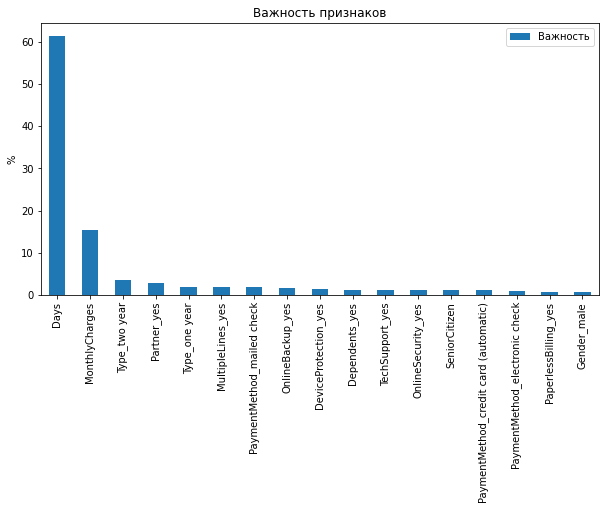

,Важность
Days,61.413607
MonthlyCharges,15.349327
Type_two year,3.520591
Partner_yes,2.807233
Type_one year,1.861085
MultipleLines_yes,1.828993
PaymentMethod_mailed check,1.805843
OnlineBackup_yes,1.734774
DeviceProtection_yes,1.394070
Dependents_yes,1.284162


In [91]:
cat_imp.plot(kind='bar', figsize=(10, 5), title='Важность признаков', ylabel='%')
plt.show()
cat_imp

Можно выделить следующие важные признаки:
- Сколько дней является клиентом
- Ежемесячная плата пользователя
- Тип оплаты на один или два года
- Наличие супруга
- Подключены несколько телефонных линий

Вопрос:
- Что нужно писать в отчете? И как его в целом нужно оформить, в виде презентации?    

# Итоговый проект (часть 3)

## Отчет

**Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов.** 

**Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.**

### Ключевые шаги в решении задачи

**Были выделены следующие ключевые шаги:**
- **Предобработка данных** на данном шаге была произведена подготовка данных к дальнейшей работе с ними и анализу, был обозначен целевой признак
- **Анализ данных** на данном шаге были выявлены взаимосвязи и корреляции категорий 
- **Подготовка данных к моделированию** финальная подготовка данных перед построением моделей, были убраны категории не нужные или мешающие корректной работе моделей
- **Моделирование** на донном этапе построены 3 модели, лучшая среди которых обучена на тестовой выборке

### Анализ соответствия фактической работы запланированным шагам

1. Предобработка данных:
- [x] Переименовать (изменить регистр) в столбцах таблиц
- [x] Изменить типы данных
- [x] Проверить на наличие дубликатов
- [ ] Работа с выбросами и аномалиями - в данных не было явных аномалий и выбросов, от которых следовало избавляться

2. Подготовка данных к моделированию:
- [x] Обьединить датасеты в один
- [x] Работа с пропусками
- [x] Работа с распределением признаков
- [x] Кодирование категориальных данных
- [x] Сформировать целевой признак на основе EndDate (добавить новый столбец)

3. Анализ данных (будет использоваться в отчете):
- [x] Исследуем корреляцию между данными
- [x] Дисбаланс классов (не обязательно) - подразумевалось машабирование классов, было выполнено

4. Модели:
- [x] Исследуем 3 модели
- [x] Разделение данных на тренировочную и тестовую выборки в соотношении 3к1
- [ ] Борьба с дисбалансом на обучаемой выборке (class_weight='balanced') - балансировка классов не проводилась, так как результаты модели весьма приемлимы
- [x] Подбираем гиперпараметры на кросс-валидации
- [x] Обучить 3 модели на тренировочной выборке
- [x] Анализ матрицы ошибок
- [x] Выбираем 1 лучшую модель
- [x] Считаем и интерпретируем метрику Accuracy (для отчета)
- [x] Анализ важности признаков
- [x] Пишем выводы по моделированию - были представлены итоговые значения обучения модели и анализ важности признаков

5. Отчет:
- [x] Написание отчета по выполненной работе

### Какие трудности возникли и как вы их преодолели

Были трудности с проверкой выборок при кодировании категориальных признаков через get_dummies, был придуман метод сопоставляющий категории из двух датасетов на идентичность

При кодировании через OrdinalEncoder кодировались абсолютно все категории. Нужно было кодировать только категориальный признаки, исключая неприрывные значения 

Повторное обучение модели после поиска лучших гиперпараметров, что уже позволяло вывести на экран метрики качества модели. Повторное обучение было удалено, что значительно сократило итоговое время обучения модели

Корреляция phik - новая метрика, для работы с которой пришлось осваивать соответствующие статьи

###  Итоговый список признаков.  Какая предобработка этих признаков была выполнена?

- Type – тип оплаты
- PaperlessBilling – электронный платёжный документ
- PaymentMethod – способ оплаты
- MonthlyCharges - размер месячный оплаты
- Gender - пол клиента
- SeniorCitizen - наличие пенсионного возраста
- Partner - наличие супруга
- Dependents – наличие иждивенцев
- OnlineSecurity - подключена ли услуга онлайн-безопасности 
- OnlineBackup - подключена ли услуга резервного копирования
- DeviceProtection - есть ли у клиента страховка на устройство
- TechSupport - подключена ли услуга технической поддержки
- MultipleLines – наличие возможности ведения параллельных линий во время звонка
- Days - какое количество дней является клиентом

Изначально признаки находились в разных датасетах, они были обьеденены в эдиную таблицу, а полученнные в результате пропуски логически заполнены

На основе признака окончания договора был получен наш целевой признак

В матрице корреляции были видны скоррелированные предикторы, создающие эффект мультиколлинеарности.
Для корректного моделирования удалили следующие признаки: TotalCharges, BeginDate, EndDate, InternetService, StreamingMovies, StreamingTV 

Категориальные признаки были закодированы цифрами, с помощью номера категории, после чего наши числовые категории (непрерывные значения) были маштабированы

### Краткое описание предобработки данных

- Визуально осмотрели предоставленные датасеты, понять какие данные вних находятся, что за категории
- Изучили типы данных, количество строк и столбцов, наличие пропусков
- Переименовали (изменить регистр) в столбцах таблиц
- Изменили типы данных на корректные
- Выделили ключевой столбец по которому можно обьеденить все датасеты
- Обьединили таблицы в единый датасет
- Избавились от пропусков в столбцах, образовавшихся после обьединения 
- Проверили на наличие дубликатов
- Создали новый столбец с целевым признаком

### Сводная таблица исследованых моделей и их метрика на кросс-валидации

In [97]:
comparison_tabl.T.style.highlight_min(color='red',subset=column).highlight_max(color='green',subset=column)

,Среднее качество модели на кросс-валидации
LogisticRegression,0.752463
RandomForestClassifier,0.821886
CatBoostClassifier,0.922982


ROC AUC - это метрика наших моделей, позволяющая выявить, как сильно наша модель отличается от случайной, не привязываясь к конкретному порогу. Это новая метрика качества, которая изменяется от 0 до 1. AUC-ROC случайной модели равна 0.5. 

### Лучшая модель

Лучше всего показала себя модель CatBoostClassifier

Код модели:

```python
RANDOM_STATE=190623

cb = CatBoostClassifier(random_state=RANDOM_STATE)

cb_parametrs = {'learning_rate': [0.03, 0.1],
                'depth': [4, 6, 10]
               }

cb_grid = GridSearchCV(cb, cb_parametrs, scoring='roc_auc')
cb_grid.fit(features_train, target_train, verbose=100)

cb_params = cb_grid.best_params_
print("Лучшие параметры модели:", cb_params)

scores_cv_cat = cb_grid.best_score_
print('Среднее качество модели CatBoost на кросс-валидации:', scores_cv_cat)

```

**Лучшие гиперпараметры**

{'depth': 4, 'learning_rate': 0.1}

**Время обучения**

3min 37s

**Качество модели**

Основная метрика модели "ROC-AUC score" на трени тренировочной выборке составляет 0.93

### Итоговые метрики на тестовой выборке

Основная метрика модели "ROC-AUC score" на тестовой выборке составляет 0.93

Доля правильных ответов (accuracy) к размеру тестовой выборки составляет 92 %

Accuracy является одним из основных метрик качества модели и используется в различных задачах машинного обучения.

Это показатель, который отображает степень соответствия между предсказаниями модели и реальными значениями. Это особенно полезно, когда каждый класс одинаково важен.

Более формально, accuracy определяется как отношение числа правильно классифицированных объектов к общему числу классифицируемых объектов в наборе данных.  

Наша модель правильно классифицирует 93 объектов из 100, то ее accuracy составит 0,93 или 93%

### Матрица ошибок

Наглядно представить результаты вычислений метрик точности и полноты позволяет матрица ошибок

In [100]:
print(confusion_matrix(target_test,pred_test_acc))

[[1465   27]
 [  89  180]]


- 1465 - Истинный положительный результат (TP): это общее количество, имеющее как прогнозируемые, так и фактические значения ушедших пользователей.
- 180 - Истинный отрицательный результат (TN): это общее количество, имеющее как прогнозируемые, так и фактические значения.
- 27 - Ложноположительный результат (FP): это общее количество, имеющее прогноз «ушел», хотя на самом деле «Не ушел».
- 89 - Ложноотрицательный (FN): это общее количество, имеющее прогноз «Не ушел», хотя на самом деле «ушел».

### Важность признаков

В итоговой модели были следующие признаки, а также наглядно виден их уровень важности

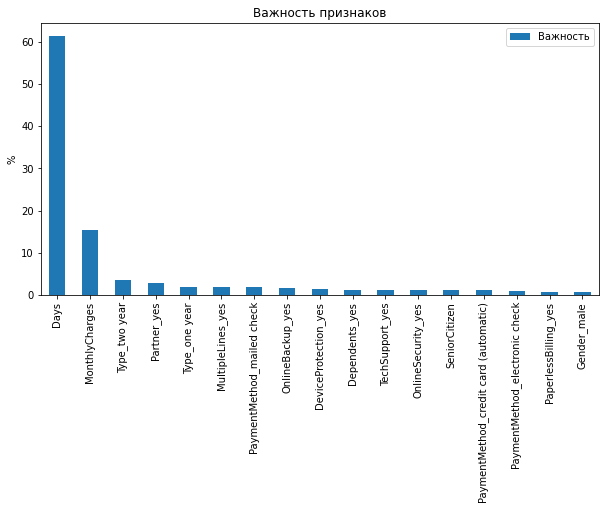

,Важность
Days,61.413607
MonthlyCharges,15.349327
Type_two year,3.520591
Partner_yes,2.807233
Type_one year,1.861085
MultipleLines_yes,1.828993
PaymentMethod_mailed check,1.805843
OnlineBackup_yes,1.734774
DeviceProtection_yes,1.394070
Dependents_yes,1.284162


In [102]:
cat_imp.plot(kind='bar', figsize=(10, 5), title='Важность признаков', ylabel='%')
plt.show()
cat_imp

Можно выделить следующие важные признаки:
- Количество дней является клиентом
- Ежемесячная плата пользователя
- Тип оплаты на один или два года 
- Наличие супруга (да)
- Подключены несколько телефонных линий